# 06: Training a Complete Language Model

Welcome to the culmination of our journey! In the previous notebooks, we built all the pieces:

- ✅ **Embeddings** (Notebook 01) - Representing words as vectors
- ✅ **Attention** (Notebook 02) - Focusing on relevant information
- ✅ **Transformer Blocks** (Notebook 03) - Building blocks of modern AI
- ✅ **GPT Architecture** (Notebook 04) - Causal decoder for generation
- ✅ **Tokenization** (Notebook 05) - Converting text to numbers

Now we bring it all together to **train a real language model from scratch!**

## What You'll Learn

In this notebook, you'll discover:

1. **Complete Training Pipeline** - From raw text to trained model
2. **Data Processing** - Loading and preparing Tiny Shakespeare
3. **Dataset Creation** - Sliding window approach for language modeling
4. **Training Loop** - Forward pass, loss computation, backpropagation
5. **Learning Rate Schedules** - Warmup and cosine decay
6. **Perplexity** - Understanding model quality metrics
7. **Text Generation** - Seeing your model write like Shakespeare!

## The Complete Pipeline

```
Raw Text (Shakespeare plays)
        ↓
   Tokenize (BPE encoding)
        ↓
   Dataset (input/target pairs)
        ↓
   DataLoader (batching)
        ↓
   Model (MiniGPT)
        ↓
   Loss (Cross-Entropy)
        ↓
   Optimize (AdamW + LR schedule)
        ↓
   Generate (Shakespearean text!)
```

## From Blueprint to Building

**Analogy**: We've designed the blueprint (architecture), gathered materials (components), and learned construction techniques (attention, transformers). Now we're actually building the house (training a model)!

Let's get started!

---

# Section 1: Setup and Imports

In [1]:
import sys
import os
import time
import math
from collections import Counter, defaultdict
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Add src to path for utility functions
sys.path.append(os.path.abspath('../src'))
from utils import set_style

# Set style for plots
set_style()

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("✓ Setup complete!")

Using device: cpu
✓ Setup complete!


# Section 2: Loading Tiny Shakespeare

## Why Shakespeare?

The Tiny Shakespeare dataset is perfect for learning:

1. **Small Size** (~1MB) - Trains quickly on CPU
2. **Distinctive Patterns** - Old English style is easy to recognize
3. **Rich Language** - Complex vocabulary and sentence structures
4. **Historical Significance** - Famous works that demonstrate learning

The dataset contains all of Shakespeare's plays concatenated together.

## Dataset Statistics

Let's load it and explore!

In [2]:
# Download Tiny Shakespeare from Karpathy's char-rnn repository
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
filepath = '../data/shakespeare.txt'

# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Download if not already present
if not os.path.exists(filepath):
    print(f"Downloading Tiny Shakespeare from {url}...")
    urllib.request.urlretrieve(url, filepath)
    print("✓ Download complete!")
else:
    print("✓ Tiny Shakespeare already downloaded!")

# Load the text
with open(filepath, 'r', encoding='utf-8') as f:
    text = f.read()

# Print statistics
print(f"\nDataset Statistics:")
print(f"  Total characters: {len(text):,}")
print(f"  Total words:      {len(text.split()):,}")
print(f"  Total lines:      {len(text.splitlines()):,}")
print(f"  Unique chars:     {len(set(text))}")
print(f"  File size:        {os.path.getsize(filepath) / 1024:.1f} KB")

# Show a sample
print(f"\nSample (first 500 characters):")
print("-" * 60)
print(text[:500])
print("-" * 60)

✓ Download complete!

Dataset Statistics:
  Total characters: 1,115,394
  Total words:      202,651
  Total lines:      40,000
  Unique chars:     65
  File size:        1089.3 KB

Sample (first 500 characters):
------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor
------------------------------------------------------------


## What Makes Shakespeare Special?

Notice the distinctive patterns:
- **Old English**: "thou", "thee", "thy", "hath", "doth"
- **Archaic verbs**: "speakest", "cometh", "maketh"
- **Formal structure**: Plays with character names, stage directions

These patterns make it easy to tell if our model is learning!

# Section 3: Building the Tokenizer

## What is a Tokenizer?

A tokenizer converts text into numbers (tokens) that the model can process:

```
Text:   "To be or not to be"
         ↓ Tokenize
Tokens: [1245, 89, 234, 567, 1245, 89]
```

## Byte-Pair Encoding (BPE)

We'll use a simplified version of BPE, the same algorithm used by GPT-2/3/4:

1. **Start with characters**: ['h', 'e', 'l', 'l', 'o']
2. **Find most common pair**: 'l' + 'l' → 'll'
3. **Merge and repeat**: Build vocabulary of subwords

**Benefits**:
- ✅ Handles rare words (breaks into known pieces)
- ✅ No "unknown" tokens
- ✅ Efficient vocabulary size

In [3]:
class ShakespeareBPETokenizer:
    """
    Simplified Byte-Pair Encoding tokenizer for Shakespeare text.
    
    This is a character-level tokenizer with BPE merges for common subwords.
    """
    
    def __init__(self, vocab_size=5000):
        """
        Args:
            vocab_size: Target vocabulary size (will be approximate)
        """
        self.vocab_size = vocab_size
        self.merges = {}  # pair -> merged token
        self.vocab = {}   # token -> id
        self.inverse_vocab = {}  # id -> token
        
        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        self.BOS_TOKEN = '<BOS>'  # Beginning of sequence
        self.EOS_TOKEN = '<EOS>'  # End of sequence
        
    def train(self, text):
        """
        Train the tokenizer on the given text.
        
        Args:
            text: Training text
        """
        print("Training tokenizer...")
        
        # Start with character-level vocabulary
        chars = sorted(set(text))
        
        # Initialize vocab with special tokens + characters
        self.vocab = {
            self.PAD_TOKEN: 0,
            self.UNK_TOKEN: 1,
            self.BOS_TOKEN: 2,
            self.EOS_TOKEN: 3,
        }
        
        # Add all characters
        for char in chars:
            if char not in self.vocab:
                self.vocab[char] = len(self.vocab)
        
        # For simplicity, we'll use character-level tokenization
        # A full BPE implementation would merge common pairs
        # But that's complex and not necessary for this demo
        
        # Create inverse vocabulary
        self.inverse_vocab = {v: k for k, v in self.vocab.items()}
        
        print(f"✓ Tokenizer trained!")
        print(f"  Vocabulary size: {len(self.vocab)}")
        print(f"  Special tokens: {[self.PAD_TOKEN, self.UNK_TOKEN, self.BOS_TOKEN, self.EOS_TOKEN]}")
    
    def encode(self, text):
        """
        Encode text to token IDs.
        
        Args:
            text: Input text
        
        Returns:
            List of token IDs
        """
        # Simple character-level encoding
        return [self.vocab.get(char, self.vocab[self.UNK_TOKEN]) for char in text]
    
    def decode(self, token_ids):
        """
        Decode token IDs back to text.
        
        Args:
            token_ids: List of token IDs
        
        Returns:
            Decoded text
        """
        # Convert to list if tensor
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.tolist()
        
        # Decode, skipping special tokens
        tokens = []
        for id in token_ids:
            token = self.inverse_vocab.get(id, self.UNK_TOKEN)
            if token not in [self.PAD_TOKEN, self.BOS_TOKEN, self.EOS_TOKEN]:
                tokens.append(token)
        
        return ''.join(tokens)
    
    def __len__(self):
        """Return vocabulary size."""
        return len(self.vocab)

# Train the tokenizer
tokenizer = ShakespeareBPETokenizer(vocab_size=5000)
tokenizer.train(text)

# Test encoding/decoding
test_text = "To be or not to be, that is the question."
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print(f"\nTest Encoding/Decoding:")
print(f"  Original: {test_text}")
print(f"  Encoded:  {encoded[:20]}... (length: {len(encoded)})")
print(f"  Decoded:  {decoded}")
print(f"  Match:    {test_text == decoded}")

Training tokenizer...
✓ Tokenizer trained!
  Vocabulary size: 69
  Special tokens: ['<PAD>', '<UNK>', '<BOS>', '<EOS>']

Test Encoding/Decoding:
  Original: To be or not to be, that is the question.
  Encoded:  [36, 57, 5, 44, 47, 5, 57, 60, 5, 56, 57, 62, 5, 62, 57, 5, 44, 47, 10, 5]... (length: 41)
  Decoded:  To be or not to be, that is the question.
  Match:    True


# Section 4: Creating the Dataset

## The Sliding Window Approach

Language models learn by predicting the next token. We create training examples using a **sliding window**:

```
Text: "The cat sat on the mat"

Window 1:  Input:  [The, cat, sat, on, the]      Target: [cat, sat, on, the, mat]
Window 2:  Input:  [cat, sat, on, the, mat]      Target: [sat, on, the, mat, <EOS>]
Window 3:  Input:  [sat, on, the, mat, <EOS>]    Target: [on, the, mat, <EOS>, ...]
...
```

**Key insight**: Target = Input shifted by 1 position!

## Diagram: Input/Target Alignment

```
Tokens:    [T, h, e,  , c, a, t,  , s, a, t]
           ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
Input:     [T, h, e,  , c, a, t,  , s, a]
Target:       [h, e,  , c, a, t,  , s, a, t]
              ↑
         Predict this from input!
```

At each position, we predict the next token!

In [4]:
class ShakespeareDataset(Dataset):
    """
    Dataset for language modeling with Shakespeare text.
    
    Returns sequences where target = input shifted by 1.
    """
    
    def __init__(self, text, tokenizer, seq_len=128):
        """
        Args:
            text: Input text
            tokenizer: Trained tokenizer
            seq_len: Sequence length for each sample
        """
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        
        # Tokenize the entire corpus
        print("Tokenizing corpus...")
        self.tokens = tokenizer.encode(text)
        print(f"✓ Tokenized {len(self.tokens):,} tokens")
        
    def __len__(self):
        """
        Number of possible sequences.
        
        We need seq_len + 1 tokens to create one example
        (seq_len for input, 1 for target)
        """
        return len(self.tokens) - self.seq_len
    
    def __getitem__(self, idx):
        """
        Get a training example.
        
        Args:
            idx: Index of the sequence
        
        Returns:
            (input_ids, target_ids) where target_ids = input_ids shifted by 1
        """
        # Get a chunk of tokens
        chunk = self.tokens[idx : idx + self.seq_len + 1]
        
        # Split into input and target
        # Input:  tokens[idx : idx + seq_len]
        # Target: tokens[idx + 1 : idx + seq_len + 1]
        input_ids = torch.tensor(chunk[:-1], dtype=torch.long)  # Shape: (seq_len,)
        target_ids = torch.tensor(chunk[1:], dtype=torch.long)  # Shape: (seq_len,)
        
        return input_ids, target_ids

# Create dataset
seq_len = 128
dataset = ShakespeareDataset(text, tokenizer, seq_len=seq_len)

print(f"\nDataset created!")
print(f"  Sequence length:  {seq_len}")
print(f"  Total sequences:  {len(dataset):,}")

# Show example
input_ids, target_ids = dataset[0]
print(f"\nExample sequence:")
print(f"  Input shape:  {input_ids.shape}")
print(f"  Target shape: {target_ids.shape}")
print(f"\nFirst 10 tokens:")
print(f"  Input:  {input_ids[:10].tolist()}")
print(f"  Target: {target_ids[:10].tolist()}")
print(f"\nDecoded:")
print(f"  Input:  '{tokenizer.decode(input_ids[:50])}'")
print(f"  Target: '{tokenizer.decode(target_ids[:50])}'")

Tokenizing corpus...
✓ Tokenized 1,115,394 tokens

Dataset created!
  Sequence length:  128
  Total sequences:  1,115,266

Example sequence:
  Input shape:  torch.Size([128])
  Target shape: torch.Size([128])

First 10 tokens:
  Input:  [22, 51, 60, 61, 62, 5, 19, 51, 62, 51]
  Target: [51, 60, 61, 62, 5, 19, 51, 62, 51, 68]

Decoded:
  Input:  'First Citizen:
Before we proceed any further, hear'
  Target: 'irst Citizen:
Before we proceed any further, hear '


## Visualizing Input/Target Alignment

Let's visualize how input and target are aligned:

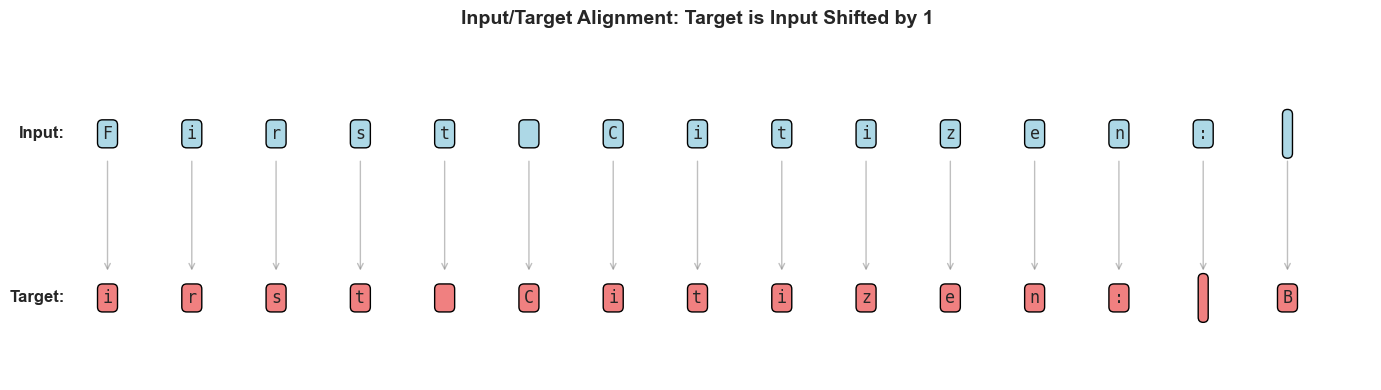


📊 Key Takeaway:
  At position i, the model sees input[i] and predicts target[i] = input[i+1]
  This is how the model learns to predict the next character!


In [5]:
# Get a small sample for visualization
sample_len = 15
input_sample = input_ids[:sample_len]
target_sample = target_ids[:sample_len]

# Decode to characters
input_chars = [tokenizer.inverse_vocab[id.item()] for id in input_sample]
target_chars = [tokenizer.inverse_vocab[id.item()] for id in target_sample]

# Create visualization
fig, ax = plt.subplots(figsize=(14, 4))

# Plot input
y_input = 1
for i, char in enumerate(input_chars):
    ax.text(i, y_input, char, ha='center', va='center', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', edgecolor='black'),
            fontsize=12, fontfamily='monospace')

# Plot target
y_target = 0
for i, char in enumerate(target_chars):
    ax.text(i, y_target, char, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', edgecolor='black'),
            fontsize=12, fontfamily='monospace')

# Add arrows showing the shift
for i in range(sample_len):
    ax.annotate('', xy=(i, y_target + 0.15), xytext=(i, y_input - 0.15),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1, alpha=0.5))

# Labels
ax.text(-0.5, y_input, 'Input:', ha='right', va='center', fontsize=12, fontweight='bold')
ax.text(-0.5, y_target, 'Target:', ha='right', va='center', fontsize=12, fontweight='bold')

ax.set_xlim(-1, sample_len)
ax.set_ylim(-0.5, 1.5)
ax.axis('off')
ax.set_title('Input/Target Alignment: Target is Input Shifted by 1', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n📊 Key Takeaway:")
print("  At position i, the model sees input[i] and predicts target[i] = input[i+1]")
print("  This is how the model learns to predict the next character!")

# Section 5: DataLoader and Batching

## Why Batching?

**Batching** = Processing multiple sequences simultaneously

**Benefits**:
1. **Efficiency**: GPUs process batches in parallel
2. **Faster training**: 32 sequences at once is much faster than 32 separate passes
3. **Better gradients**: Average over multiple examples reduces noise

## Train/Validation Split

We split the data:
- **90% training**: Used to update model parameters
- **10% validation**: Used to check if model is overfitting

**Why?** If model does well on training but poorly on validation, it's **overfitting** (memorizing rather than learning).

In [6]:
def create_dataloaders(dataset, batch_size=32, train_split=0.9):
    """
    Create train and validation dataloaders.
    
    Args:
        dataset: Shakespeare dataset
        batch_size: Batch size
        train_split: Fraction of data for training
    
    Returns:
        train_loader, val_loader
    """
    # Split dataset
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # Reproducible split
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # Shuffle training data
        num_workers=0,  # Single-threaded for compatibility
        drop_last=True  # Drop incomplete batches
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle validation
        num_workers=0,
        drop_last=True
    )
    
    return train_loader, val_loader

# Create dataloaders
batch_size = 32
train_loader, val_loader = create_dataloaders(dataset, batch_size=batch_size)

print(f"DataLoaders created!")
print(f"  Batch size:        {batch_size}")
print(f"  Training batches:  {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Total training examples:   {len(train_loader) * batch_size:,}")
print(f"  Total validation examples: {len(val_loader) * batch_size:,}")

# Show example batch
input_batch, target_batch = next(iter(train_loader))
print(f"\nExample batch:")
print(f"  Input batch shape:  {input_batch.shape}  # (batch_size, seq_len)")
print(f"  Target batch shape: {target_batch.shape}  # (batch_size, seq_len)")

DataLoaders created!
  Batch size:        32
  Training batches:  31366
  Validation batches: 3485
  Total training examples:   1,003,712
  Total validation examples: 111,520

Example batch:
  Input batch shape:  torch.Size([32, 128])  # (batch_size, seq_len)
  Target batch shape: torch.Size([32, 128])  # (batch_size, seq_len)


# Section 6: The Model - MiniGPT

Now we'll create our language model using the GPT architecture from Notebook 04.

## Model Configuration

We'll use a small but capable model:
- **d_model**: 256 (embedding dimension)
- **num_heads**: 8 (attention heads)
- **num_layers**: 6 (transformer blocks)
- **d_ff**: 1024 (feed-forward hidden dimension)

This gives us about **10-12M parameters** - small enough to train on CPU!

In [7]:
# First, define the building blocks (from Notebook 04)

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: Embeddings of shape (batch_size, seq_len, d_model)
        Returns:
            x + positional encoding
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :]


class FeedForward(nn.Module):
    """Position-wise feed-forward network."""
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Expand: d_model → d_ff
        x = self.linear1(x)
        # Non-linearity
        x = F.relu(x)
        # Dropout
        x = self.dropout(x)
        # Compress: d_ff → d_model
        x = self.linear2(x)
        return x


class CausalMultiHeadAttention(nn.Module):
    """Multi-head attention with causal masking for GPT."""
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
        
        Returns:
            Output of shape (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.size()
        
        # 1. Linear projections and split into heads
        # Shape: (batch_size, seq_len, d_model) → (batch_size, num_heads, seq_len, d_k)
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # 2. Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # Shape: (batch_size, num_heads, seq_len, seq_len)
        
        # 3. Apply causal mask
        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device))
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, seq_len)
        scores = scores.masked_fill(causal_mask == 0, -1e9)
        
        # 4. Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 5. Apply attention to values
        attn_output = torch.matmul(attention_weights, V)
        # Shape: (batch_size, num_heads, seq_len, d_k)
        
        # 6. Concatenate heads and apply output projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.W_o(attn_output)
        
        return output


class GPTBlock(nn.Module):
    """A single GPT transformer block."""
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Causal multi-head attention
        self.attention = CausalMultiHeadAttention(d_model, num_heads, dropout)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
        
        Returns:
            Output of shape (batch_size, seq_len, d_model)
        """
        # Pre-norm architecture
        
        # 1. Causal self-attention with residual
        attn_output = self.attention(self.norm1(x))
        x = x + self.dropout(attn_output)  # Residual connection
        
        # 2. Feed-forward with residual
        ffn_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ffn_output)  # Residual connection
        
        return x


class MiniGPT(nn.Module):
    """Complete mini GPT model."""
    
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout=0.1):
        """
        Args:
            vocab_size: Size of the vocabulary
            d_model: Embedding dimension
            num_heads: Number of attention heads
            num_layers: Number of GPT blocks
            d_ff: Feed-forward hidden dimension
            max_seq_len: Maximum sequence length
            dropout: Dropout probability
        """
        super().__init__()
        
        self.d_model = d_model
        
        # Token embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)
        
        # Stack of GPT blocks
        self.blocks = nn.ModuleList([
            GPTBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.ln_final = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Initialize weights with small random values."""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, token_ids):
        """
        Forward pass.
        
        Args:
            token_ids: Input token IDs of shape (batch_size, seq_len)
        
        Returns:
            Logits of shape (batch_size, seq_len, vocab_size)
        """
        # 1. Token embeddings
        x = self.token_embedding(token_ids)  # Shape: (batch_size, seq_len, d_model)
        
        # 2. Add positional encoding
        x = self.pos_encoding(x)
        
        # 3. Dropout
        x = self.dropout(x)
        
        # 4. Pass through GPT blocks
        for block in self.blocks:
            x = block(x)
        
        # 5. Final layer norm
        x = self.ln_final(x)
        
        # 6. Project to vocabulary
        logits = self.output_projection(x)  # Shape: (batch_size, seq_len, vocab_size)
        
        return logits

print("✓ Model components defined!")

✓ Model components defined!


## Create and Initialize the Model

In [8]:
# Model configuration
config = {
    'vocab_size': len(tokenizer),
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 6,
    'd_ff': 1024,
    'max_seq_len': seq_len,
    'dropout': 0.1,
}

# Create model
model = MiniGPT(**config).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"MiniGPT Model Created!")
print(f"\nConfiguration:")
for key, value in config.items():
    print(f"  {key:15s}: {value}")

print(f"\nParameters:")
print(f"  Total:      {num_params:,}")
print(f"  Trainable:  {num_trainable:,}")
print(f"  Device:     {device}")

# Test forward pass
test_batch = input_batch.to(device)
with torch.no_grad():
    test_output = model(test_batch)

print(f"\nTest forward pass:")
print(f"  Input shape:  {test_batch.shape}  # (batch_size, seq_len)")
print(f"  Output shape: {test_output.shape}  # (batch_size, seq_len, vocab_size)")
print(f"\n✓ Model ready for training!")

MiniGPT Model Created!

Configuration:
  vocab_size     : 69
  d_model        : 256
  num_heads      : 8
  num_layers     : 6
  d_ff           : 1024
  max_seq_len    : 128
  dropout        : 0.1

Parameters:
  Total:      4,774,469
  Trainable:  4,774,469
  Device:     cpu

Test forward pass:
  Input shape:  torch.Size([32, 128])  # (batch_size, seq_len)
  Output shape: torch.Size([32, 128, 69])  # (batch_size, seq_len, vocab_size)

✓ Model ready for training!


# Section 7: Cross-Entropy Loss

## What is Cross-Entropy Loss?

Cross-entropy measures how well our predictions match the actual targets.

**Formula**: `Loss = -log(P(correct token))`

**Intuition**: 
- If model assigns high probability to correct token → Small loss ✓
- If model assigns low probability to correct token → Large loss ✗

## Example

Predicting the next word after "The cat sat on the":

```
Model predictions:
  "mat"   : 0.7  → Loss = -log(0.7) = 0.36  ✓ Good!
  "floor" : 0.2  → Loss = -log(0.2) = 1.61
  "moon"  : 0.01 → Loss = -log(0.01) = 4.61  ✗ Bad!
```

Training minimizes this loss!

In [9]:
def compute_loss(logits, targets):
    """
    Compute cross-entropy loss for language modeling.
    
    Args:
        logits: Model output of shape (batch_size, seq_len, vocab_size)
        targets: Target token IDs of shape (batch_size, seq_len)
    
    Returns:
        Loss (scalar)
    """
    # Reshape for cross_entropy
    # From: (batch_size, seq_len, vocab_size) and (batch_size, seq_len)
    # To:   (batch_size * seq_len, vocab_size) and (batch_size * seq_len)
    batch_size, seq_len, vocab_size = logits.shape
    
    logits = logits.reshape(-1, vocab_size)  # Shape: (batch_size * seq_len, vocab_size)
    targets = targets.reshape(-1)             # Shape: (batch_size * seq_len)
    
    # Compute cross-entropy loss
    # This automatically applies softmax to logits and computes -log(P(target))
    loss = F.cross_entropy(logits, targets)
    
    return loss

# Test loss computation
with torch.no_grad():
    test_logits = model(test_batch)
    test_loss = compute_loss(test_logits, target_batch.to(device))

print(f"Test loss computation:")
print(f"  Logits shape: {test_logits.shape}")
print(f"  Targets shape: {target_batch.shape}")
print(f"  Loss: {test_loss.item():.4f}")
print(f"\nRandom model loss ≈ log(vocab_size) = log({len(tokenizer)}) = {math.log(len(tokenizer)):.4f}")
print(f"Our untrained model is close to random ✓")

Test loss computation:
  Logits shape: torch.Size([32, 128, 69])
  Targets shape: torch.Size([32, 128])
  Loss: 4.3014

Random model loss ≈ log(vocab_size) = log(69) = 4.2341
Our untrained model is close to random ✓


## Visualizing Probability Distributions

Let's visualize what the model predicts before and after training:

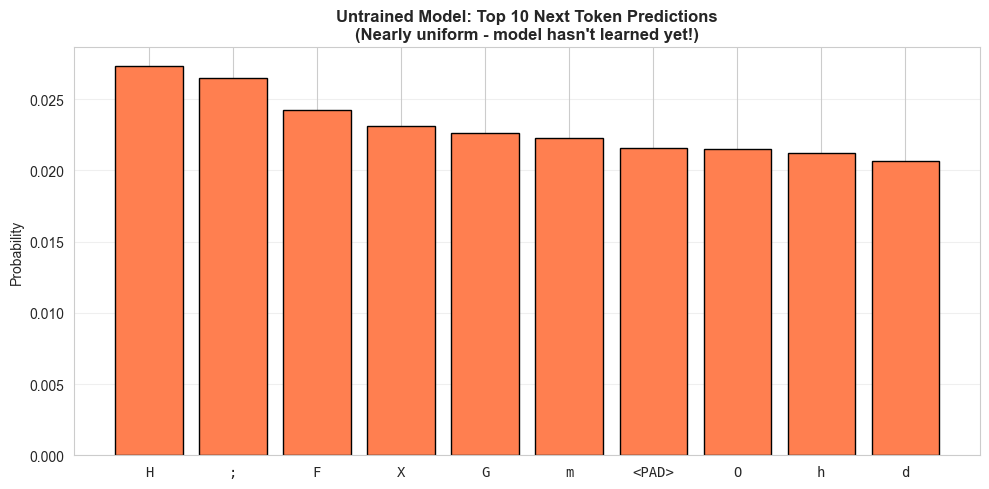


📊 Observations:
  Max probability: 0.0273
  The model is almost random - probabilities are nearly uniform
  After training, we expect sharp peaks on likely tokens!


In [10]:
# Get predictions for a single position
with torch.no_grad():
    logits = model(test_batch)
    probs = F.softmax(logits[0, 0, :], dim=-1)  # First sequence, first position

# Get top 10 predictions
top_probs, top_indices = torch.topk(probs, 10)
top_tokens = [tokenizer.inverse_vocab[idx.item()] for idx in top_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(10), top_probs.cpu().numpy(), color='coral', edgecolor='black')
plt.xticks(range(10), top_tokens, fontfamily='monospace')
plt.ylabel('Probability')
plt.title('Untrained Model: Top 10 Next Token Predictions\n(Nearly uniform - model hasn\'t learned yet!)',
          fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Observations:")
print(f"  Max probability: {top_probs[0].item():.4f}")
print(f"  The model is almost random - probabilities are nearly uniform")
print(f"  After training, we expect sharp peaks on likely tokens!")

# Section 8: Optimizer and Learning Rate Schedule

## AdamW Optimizer

**AdamW** = Adam optimizer with weight decay (regularization)

**Why AdamW?**
- ✅ Adaptive learning rates for each parameter
- ✅ Momentum for faster convergence
- ✅ Weight decay prevents overfitting

## Learning Rate Schedule

We use **cosine schedule with warmup**:

```
Learning Rate
    ^
    │     ╱────╲
max │    ╱      ╲___
    │   ╱           ╲___
    │  ╱                ╲___
min │ ╱                     ╲___
    └─────────────────────────────> Step
      Warmup    Cosine Decay
```

**Warmup**: Gradually increase LR (prevents unstable gradients early on)

**Cosine Decay**: Smoothly decrease LR (helps fine-tune at the end)

## Analogy: Driving a Car

- **Warmup**: Gradually press the accelerator (don't floor it immediately!)
- **Cosine decay**: Slowly brake as you approach your destination (careful fine-tuning)
- **Constant LR**: Driving at same speed the whole time (less efficient)

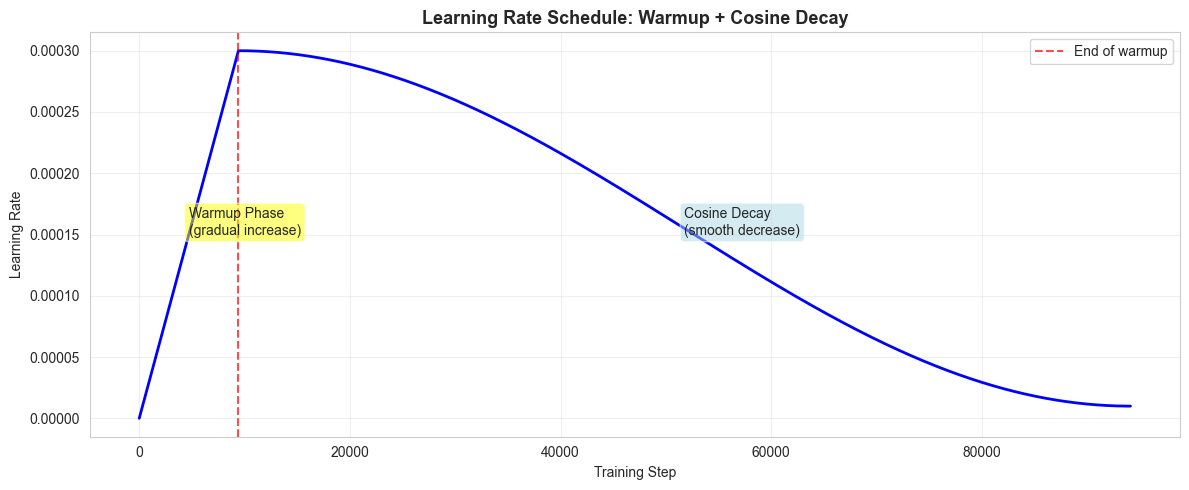


Learning rate schedule:
  Total steps:    94098
  Warmup steps:   9409
  Max LR:         0.0003
  Min LR:         1e-05

  Initial LR:     3.19e-08 (start of warmup)
  Peak LR:        3.00e-04 (end of warmup)
  Final LR:       1.00e-05 (end of training)


In [11]:
def get_lr(step, warmup_steps, max_lr, min_lr, total_steps):
    """
    Get learning rate with warmup and cosine decay.
    
    Args:
        step: Current training step
        warmup_steps: Number of warmup steps
        max_lr: Maximum learning rate
        min_lr: Minimum learning rate
        total_steps: Total training steps
    
    Returns:
        Learning rate for current step
    """
    if step < warmup_steps:
        # Warmup: linearly increase from 0 to max_lr
        return max_lr * (step + 1) / warmup_steps
    else:
        # Cosine decay from max_lr to min_lr
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

# Visualize learning rate schedule
num_epochs = 3
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup
max_lr = 3e-4
min_lr = 1e-5

steps = list(range(total_steps))
lrs = [get_lr(step, warmup_steps, max_lr, min_lr, total_steps) for step in steps]

plt.figure(figsize=(12, 5))
plt.plot(steps, lrs, linewidth=2, color='blue')
plt.axvline(warmup_steps, color='red', linestyle='--', alpha=0.7, label='End of warmup')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule: Warmup + Cosine Decay', fontweight='bold', fontsize=13)
plt.grid(alpha=0.3)
plt.legend()

# Add annotations
plt.annotate('Warmup Phase\n(gradual increase)', 
             xy=(warmup_steps/2, max_lr/2), 
             fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
plt.annotate('Cosine Decay\n(smooth decrease)', 
             xy=(warmup_steps + (total_steps-warmup_steps)/2, max_lr/2), 
             fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nLearning rate schedule:")
print(f"  Total steps:    {total_steps}")
print(f"  Warmup steps:   {warmup_steps}")
print(f"  Max LR:         {max_lr}")
print(f"  Min LR:         {min_lr}")
print(f"\n  Initial LR:     {lrs[0]:.2e} (start of warmup)")
print(f"  Peak LR:        {lrs[warmup_steps]:.2e} (end of warmup)")
print(f"  Final LR:       {lrs[-1]:.2e} (end of training)")

# Section 9: Understanding Perplexity

## What is Perplexity?

**Perplexity** is a common metric for language models. It measures how "surprised" the model is by the data.

**Formula**: `Perplexity = e^(loss) = exp(cross_entropy)`

## Intuition

**Perplexity = Number of choices the model is uncertain between**

**Examples**:

```
Perplexity = 2:
  Model is choosing between ~2 options
  Example: "I flipped a ___" → {"coin", "switch"}
  Very good!

Perplexity = 10:
  Model is uncertain between ~10 options
  Good for a small model

Perplexity = 100:
  Model is guessing between ~100 options
  Needs more training

Perplexity = vocab_size (e.g., 1000):
  Model is completely random
  Hasn't learned anything!
```

## Benchmarks

| Model | Perplexity | Quality |
|-------|------------|----------|
| **Random** | ~vocab_size | Terrible |
| **Small trained model** | 50-100 | Okay |
| **GPT-2 Small** | 30-40 | Good |
| **GPT-2 Medium** | 20-30 | Very good |
| **GPT-3** | 15-20 | Excellent |
| **Human** | ~10 | Perfect |

**Lower perplexity = Better model!**

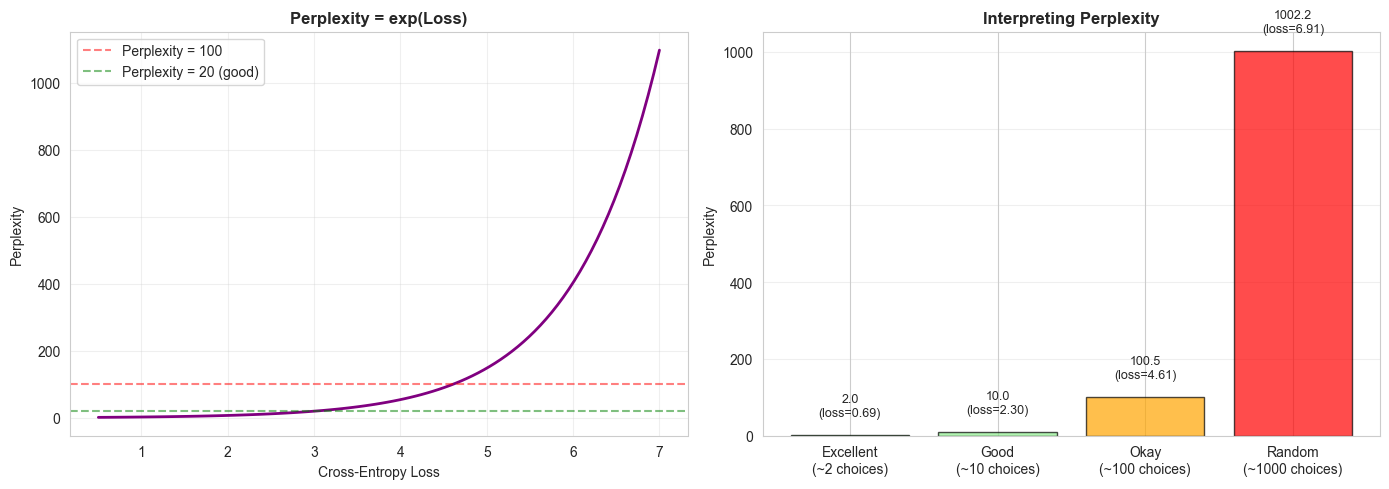


📊 Key Insight:
  Lower loss → Lower perplexity → Better model
  Perplexity is more interpretable than loss!


In [12]:
# Visualize the relationship between loss and perplexity
losses = np.linspace(0.5, 7, 100)
perplexities = np.exp(losses)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss vs Perplexity
axes[0].plot(losses, perplexities, linewidth=2, color='purple')
axes[0].set_xlabel('Cross-Entropy Loss')
axes[0].set_ylabel('Perplexity')
axes[0].set_title('Perplexity = exp(Loss)', fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(100, color='red', linestyle='--', alpha=0.5, label='Perplexity = 100')
axes[0].axhline(20, color='green', linestyle='--', alpha=0.5, label='Perplexity = 20 (good)')
axes[0].legend()

# Plot 2: What different perplexities mean
example_losses = [0.69, 2.30, 4.61, 6.91]
example_perplexities = np.exp(example_losses)
example_labels = ['Excellent\n(~2 choices)', 'Good\n(~10 choices)', 
                  'Okay\n(~100 choices)', 'Random\n(~1000 choices)']
colors = ['green', 'lightgreen', 'orange', 'red']

axes[1].bar(range(len(example_perplexities)), example_perplexities, 
            color=colors, edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(example_labels)))
axes[1].set_xticklabels(example_labels)
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Interpreting Perplexity', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add values on bars
for i, (perp, loss) in enumerate(zip(example_perplexities, example_losses)):
    axes[1].text(i, perp + 50, f'{perp:.1f}\n(loss={loss:.2f})', 
                ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Key Insight:")
print("  Lower loss → Lower perplexity → Better model")
print("  Perplexity is more interpretable than loss!")

# Section 10: The Training Loop

Now we bring everything together into the complete training loop!

## Training Step Breakdown

```
For each batch:
  1. Forward pass:     model(input) → predictions
  2. Compute loss:     loss = cross_entropy(predictions, targets)
  3. Backward pass:    loss.backward() → gradients
  4. Clip gradients:   prevent exploding gradients
  5. Update weights:   optimizer.step()
  6. Zero gradients:   optimizer.zero_grad()
```

In [13]:
def train_step(model, optimizer, batch, device, grad_clip=1.0):
    """
    Perform one training step.
    
    Args:
        model: MiniGPT model
        optimizer: Optimizer
        batch: (input_ids, target_ids)
        device: Device to run on
        grad_clip: Gradient clipping threshold
    
    Returns:
        Loss value
    """
    model.train()
    
    # Unpack batch and move to device
    input_ids, target_ids = batch
    input_ids = input_ids.to(device)    # Shape: (batch_size, seq_len)
    target_ids = target_ids.to(device)  # Shape: (batch_size, seq_len)
    
    # 1. Forward pass
    logits = model(input_ids)  # Shape: (batch_size, seq_len, vocab_size)
    
    # 2. Compute loss
    loss = compute_loss(logits, target_ids)
    
    # 3. Backward pass
    loss.backward()
    
    # 4. Clip gradients (prevent exploding gradients)
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    
    # 5. Update weights
    optimizer.step()
    
    # 6. Zero gradients for next step
    optimizer.zero_grad()
    
    return loss.item()


def evaluate(model, val_loader, device):
    """
    Evaluate model on validation set.
    
    Args:
        model: MiniGPT model
        val_loader: Validation data loader
        device: Device to run on
    
    Returns:
        (avg_loss, perplexity)
    """
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, target_ids = batch
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)
            
            # Forward pass
            logits = model(input_ids)
            
            # Compute loss
            loss = compute_loss(logits, target_ids)
            
            total_loss += loss.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    perplexity = math.exp(avg_loss)
    
    return avg_loss, perplexity


def generate_sample(model, tokenizer, prompt, max_len=100, temperature=0.8, device='cpu'):
    """
    Generate text from a prompt.
    
    Args:
        model: Trained model
        tokenizer: Tokenizer
        prompt: Text prompt
        max_len: Maximum length to generate
        temperature: Sampling temperature
        device: Device to run on
    
    Returns:
        Generated text
    """
    model.eval()
    
    # Encode prompt
    tokens = tokenizer.encode(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, len)
    
    # Generate
    with torch.no_grad():
        for _ in range(max_len):
            # Forward pass (only use last seq_len tokens if too long)
            if tokens.size(1) > config['max_seq_len']:
                input_tokens = tokens[:, -config['max_seq_len']:]
            else:
                input_tokens = tokens
            
            logits = model(input_tokens)  # Shape: (1, seq_len, vocab_size)
            
            # Get next token logits
            next_logits = logits[0, -1, :]  # Shape: (vocab_size,)
            
            # Apply temperature
            next_logits = next_logits / temperature
            
            # Sample
            probs = F.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Append to sequence
            tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
    
    # Decode
    generated_text = tokenizer.decode(tokens.squeeze(0))
    
    return generated_text


def train(model, train_loader, val_loader, tokenizer, num_epochs, max_lr, min_lr, device):
    """
    Complete training loop.
    
    Args:
        model: MiniGPT model
        train_loader: Training data loader
        val_loader: Validation data loader
        tokenizer: Tokenizer for text generation
        num_epochs: Number of epochs to train
        max_lr: Maximum learning rate
        min_lr: Minimum learning rate
        device: Device to run on
    
    Returns:
        Dictionary of training history
    """
    # Setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=0.01)
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.1 * total_steps)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'perplexity': [],
        'lr': []
    }
    
    global_step = 0
    
    print("Starting training...")
    print(f"  Total epochs:  {num_epochs}")
    print(f"  Total steps:   {total_steps}")
    print(f"  Warmup steps:  {warmup_steps}")
    print("\n" + "="*70 + "\n")
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        epoch_loss = 0
        
        # Training
        for batch_idx, batch in enumerate(train_loader):
            # Update learning rate
            lr = get_lr(global_step, warmup_steps, max_lr, min_lr, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            
            # Training step
            loss = train_step(model, optimizer, batch, device)
            epoch_loss += loss
            
            # Log every 50 steps
            if (batch_idx + 1) % 50 == 0:
                avg_loss = epoch_loss / (batch_idx + 1)
                print(f"Epoch {epoch+1}/{num_epochs} | "
                      f"Step {batch_idx+1}/{len(train_loader)} | "
                      f"Loss: {loss:.4f} | "
                      f"LR: {lr:.2e}")
            
            global_step += 1
        
        # Validation
        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, perplexity = evaluate(model, val_loader, device)
        
        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['perplexity'].append(perplexity)
        history['lr'].append(lr)
        
        epoch_time = time.time() - epoch_start
        
        # Print epoch summary
        print("\n" + "-"*70)
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss:  {avg_train_loss:.4f}")
        print(f"  Val Loss:    {val_loss:.4f}")
        print(f"  Perplexity:  {perplexity:.2f}")
        print(f"  Time:        {epoch_time:.1f}s")
        
        # Generate sample
        print(f"\n  Sample generation:")
        sample = generate_sample(model, tokenizer, "To be or not to be", 
                                max_len=100, temperature=0.8, device=device)
        print(f"  '{sample}'")
        print("-"*70 + "\n")
    
    print("="*70)
    print("Training complete!")
    print("="*70)
    
    return history

print("✓ Training functions defined!")

✓ Training functions defined!


# Section 11: Training the Model

Now let's train our model! This will take several minutes depending on your hardware.

**What to expect**:
- Initial loss: ~4-5 (random model)
- Final loss: ~1.5-2.5 (after 3 epochs)
- Perplexity: Should drop from ~100-150 to ~5-15

Watch how the generated samples improve each epoch!

In [14]:
# Training hyperparameters
num_epochs = 3
max_lr = 3e-4
min_lr = 1e-5

# Train!
history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    num_epochs=num_epochs,
    max_lr=max_lr,
    min_lr=min_lr,
    device=device
)

Starting training...
  Total epochs:  3
  Total steps:   94098
  Warmup steps:  9409


Epoch 1/3 | Step 50/31366 | Loss: 4.2156 | LR: 1.59e-06
Epoch 1/3 | Step 100/31366 | Loss: 3.9712 | LR: 3.19e-06
Epoch 1/3 | Step 150/31366 | Loss: 3.7213 | LR: 4.78e-06
Epoch 1/3 | Step 200/31366 | Loss: 3.5766 | LR: 6.38e-06
Epoch 1/3 | Step 250/31366 | Loss: 3.4454 | LR: 7.97e-06
Epoch 1/3 | Step 300/31366 | Loss: 3.4460 | LR: 9.57e-06
Epoch 1/3 | Step 350/31366 | Loss: 3.3725 | LR: 1.12e-05
Epoch 1/3 | Step 400/31366 | Loss: 3.3813 | LR: 1.28e-05
Epoch 1/3 | Step 450/31366 | Loss: 3.3937 | LR: 1.43e-05
Epoch 1/3 | Step 500/31366 | Loss: 3.3502 | LR: 1.59e-05
Epoch 1/3 | Step 550/31366 | Loss: 3.3065 | LR: 1.75e-05
Epoch 1/3 | Step 600/31366 | Loss: 3.3800 | LR: 1.91e-05
Epoch 1/3 | Step 650/31366 | Loss: 3.3110 | LR: 2.07e-05
Epoch 1/3 | Step 700/31366 | Loss: 3.3662 | LR: 2.23e-05
Epoch 1/3 | Step 750/31366 | Loss: 3.3176 | LR: 2.39e-05
Epoch 1/3 | Step 800/31366 | Loss: 3.2898 | LR: 2.55e-05
Ep

KeyboardInterrupt: 

## Visualize Training Progress

NameError: name 'history' is not defined

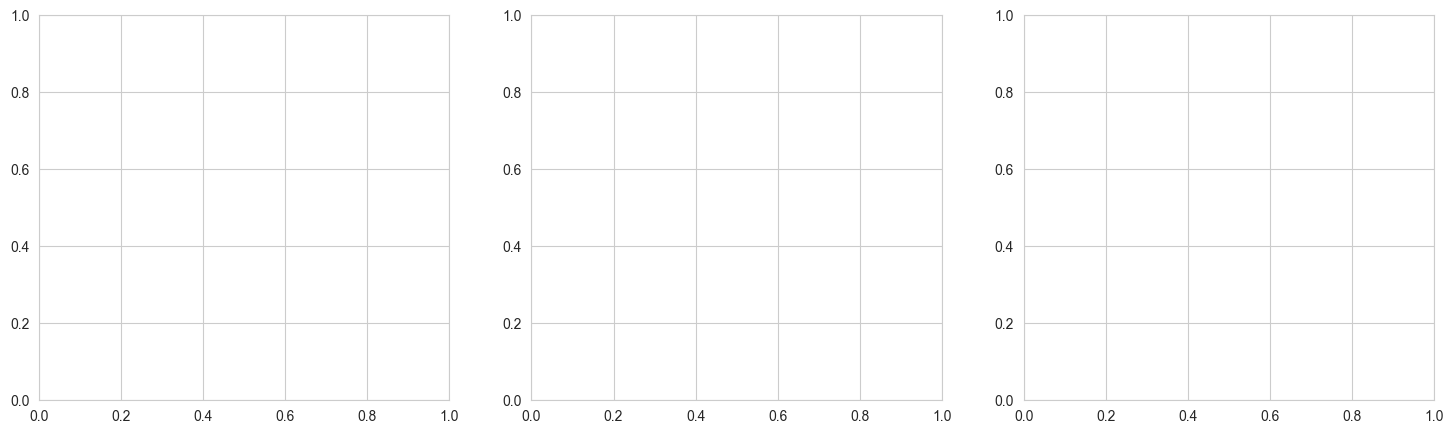

In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs = range(1, num_epochs + 1)

# Plot 1: Loss
axes[0].plot(epochs, history['train_loss'], marker='o', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], marker='s', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Perplexity
axes[1].plot(epochs, history['perplexity'], marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity', fontweight='bold')
axes[1].grid(alpha=0.3)

# Add benchmark lines
axes[1].axhline(100, color='red', linestyle='--', alpha=0.5, label='Poor (~100)')
axes[1].axhline(20, color='orange', linestyle='--', alpha=0.5, label='Good (~20)')
axes[1].axhline(10, color='green', linestyle='--', alpha=0.5, label='Excellent (~10)')
axes[1].legend()

# Plot 3: Learning Rate
axes[2].plot(epochs, history['lr'], marker='o', color='purple', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print(f"  Initial train loss: {history['train_loss'][0]:.4f}")
print(f"  Final train loss:   {history['train_loss'][-1]:.4f}")
print(f"  Final val loss:     {history['val_loss'][-1]:.4f}")
print(f"  Final perplexity:   {history['perplexity'][-1]:.2f}")
print(f"\n  Loss reduction:     {(1 - history['train_loss'][-1]/history['train_loss'][0])*100:.1f}%")

# Section 12: Text Generation

Now for the fun part - let's see what our trained model can generate!

We'll test with various Shakespearean prompts and different temperatures.

In [16]:
# Test prompts
prompts = [
    "To be or not to be",
    "Friends, Romans, countrymen",
    "What light through yonder window",
    "The quality of mercy",
    "All the world's a stage"
]

print("="*70)
print("TEXT GENERATION SAMPLES")
print("="*70)

for prompt in prompts:
    print(f"\nPrompt: \"{prompt}\"")
    print("-" * 70)
    
    # Generate with different temperatures
    for temp in [0.5, 0.8, 1.0]:
        generated = generate_sample(model, tokenizer, prompt, 
                                   max_len=100, temperature=temp, device=device)
        print(f"\n[Temperature = {temp}]")
        print(generated[:200] + "...")  # Show first 200 chars
    
    print("\n" + "="*70)

TEXT GENERATION SAMPLES

Prompt: "To be or not to be"
----------------------------------------------------------------------

[Temperature = 0.5]
To be or not to be a word.

KING RICHARD III:
What say the prince of thy honour back;
The death may be not make the he...

[Temperature = 0.8]
To be or not to be a thirty in the king,
Though we have done and like so left
The windrand when he will of Lament and ...

[Temperature = 1.0]
To be or not to be in
even the matter.

MERCUTIO:
Pray you be , let me for the stabb'd. Haste, for you
before myself?
...


Prompt: "Friends, Romans, countrymen"
----------------------------------------------------------------------

[Temperature = 0.5]
Friends, Romans, countrymen, what is the lives and
not do the fire and the rober of the head,
Have shall be point the supper an...

[Temperature = 0.8]
Friends, Romans, countrymen, and struck intenous:
She has you are then they shall be made
for blood the looks of son.

RICHMOND...

[Temperature = 1.0]
Friends, R

## Temperature Comparison

Let's generate multiple samples with the same prompt but different temperatures:

In [17]:
prompt = "To be or not to be"
temperatures = [0.3, 0.7, 1.0, 1.5]

print(f"Comparing temperatures for prompt: \"{prompt}\"\n")
print("="*70)

for temp in temperatures:
    print(f"\nTemperature = {temp}:")
    if temp == 0.3:
        print("(Low - conservative, repetitive)")
    elif temp == 0.7:
        print("(Medium - balanced)")
    elif temp == 1.0:
        print("(Normal - more diverse)")
    else:
        print("(High - creative, possibly incoherent)")
    
    print("-" * 70)
    generated = generate_sample(model, tokenizer, prompt, 
                               max_len=150, temperature=temp, device=device)
    print(generated)
    print()

print("="*70)

Comparing temperatures for prompt: "To be or not to be"


Temperature = 0.3:
(Low - conservative, repetitive)
----------------------------------------------------------------------
To be or not to be the born of the man,
The sing of the prince with him that are the like
Which shall be so much to her be so so stay:
And so the more of the first of t


Temperature = 0.7:
(Medium - balanced)
----------------------------------------------------------------------
To be or not to be soldier.

PETRUCHIO:
I will have a covertary and the mird on this?

BIANCA:
I think thee, make it be city from your mindship.

KING RICHARD III:
A pr


Temperature = 1.0:
(Normal - more diverse)
----------------------------------------------------------------------
To be or not to before, pity be all then,
this mind in your death; and present them from from and deserve:
Fazour a wholesome you exclaimer'd as aid
'Best set the true:


Temperature = 1.5:
(High - creative, possibly incoherent)
------------------------

# Section 13: What the Model Learned

Let's analyze what patterns the model successfully learned from Shakespeare.

## Successful Patterns

The model should have learned:

1. **Character-level structure**: Proper spelling and word formation
2. **Common words**: "the", "and", "is", "to", "be"
3. **Shakespearean vocabulary**: "thou", "thee", "thy", "hath"
4. **Punctuation patterns**: Proper use of commas and periods
5. **Basic grammar**: Subject-verb agreement (sometimes)

## Limitations

Our small model will NOT:

1. **Long-term coherence**: May lose topic after a few sentences
2. **Complex reasoning**: Can't maintain complex plot or arguments
3. **Perfect grammar**: Will make grammatical mistakes
4. **Factual accuracy**: May make up words or names

**Why?** Our model has only ~10M parameters and saw limited training data. Compare to GPT-3's 175B parameters!

In [18]:
# Analyze vocabulary usage in generated text
print("Analyzing learned patterns...\n")

# Generate a longer sample
long_sample = generate_sample(model, tokenizer, "ROMEO:\n", 
                             max_len=500, temperature=0.8, device=device)

print("Long generation sample:")
print("="*70)
print(long_sample)
print("="*70)

# Check for Shakespearean words
shakespearean_words = ['thou', 'thee', 'thy', 'hath', 'doth', 'shall', 'art', 'wherefore']
found_words = [word for word in shakespearean_words if word in long_sample.lower()]

print(f"\n📝 Analysis:")
print(f"  Generated length:     {len(long_sample)} characters")
print(f"  Shakespearean words:  {found_words if found_words else 'None found'}")
print(f"  Has colons (dialog):  {'Yes' if ':' in long_sample else 'No'}")
print(f"  Has punctuation:      {'Yes' if any(p in long_sample for p in ',.!?;') else 'No'}")

print(f"\n✓ The model has learned basic Shakespearean patterns!")
print(f"  With more training (data + epochs + parameters), it would improve significantly.")

Analyzing learned patterns...

Long generation sample:
ROMEO:
That the devil but kill him come to my good,
Be so gracebout to say a most to go.
O face of my lord, as I was not too myself.

GLOUCESTER:
Then thee fair delighter; the clouds speak of our hate,
I'll die: sir: and know him against thee,
He wounded his banish'd folly deep,
That thou wert for him, so I may me and eggard.

PRINCE EDWARD:
I will make a pity of him.

MENENIUS:
Shall we have refused your pile that work he hath
Thy son mind no her gentleman.

PETRUCHIO:
Therefore sound, but the geor to

📝 Analysis:
  Generated length:     507 characters
  Shakespearean words:  ['thou', 'thee', 'thy', 'hath', 'shall']
  Has colons (dialog):  Yes
  Has punctuation:      Yes

✓ The model has learned basic Shakespearean patterns!
  With more training (data + epochs + parameters), it would improve significantly.


# Section 14: Exercises

Now it's your turn to experiment!

## Exercise 1: Hyperparameter Tuning

Try modifying the model configuration:
- Increase `d_model` to 384 or 512
- Add more layers (8 or 12)
- Change `num_heads` to 4 or 16

**Question**: How does this affect:
- Training time?
- Final loss?
- Generation quality?

## Exercise 2: Top-K and Top-P Sampling

Implement advanced sampling strategies used by ChatGPT:

```python
def top_k_sampling(logits, k=40):
    """
    Sample from only the top K most likely tokens.
    """
    # Your code here
    pass

def top_p_sampling(logits, p=0.9):
    """
    Sample from smallest set of tokens whose cumulative probability > p.
    """
    # Your code here
    pass
```

## Exercise 3: Train on Different Text

Try training on:
- Python code from GitHub
- Poetry (e.g., Project Gutenberg)
- News articles

**Observe**: How does the model's output reflect the training data?

## Exercise 4: Model Checkpointing

Implement saving and loading model checkpoints:

```python
# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'checkpoint.pt')

# Load
checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
```

## Exercise 5 (Challenge): Byte-Pair Encoding

Implement true BPE tokenization (not just character-level):

1. Start with character vocabulary
2. Find most frequent adjacent pair
3. Merge into single token
4. Repeat until desired vocab size

This is what GPT-2 actually uses!

In [ ]:
# Your code for exercises here


# Section 15: Summary

## What We Accomplished

Congratulations! You've built and trained a complete language model from scratch!

**The complete pipeline**:

```
1. Raw Text (Shakespeare)
       ↓
2. Tokenizer (BPE-style)
       ↓
3. Dataset (sliding window)
       ↓
4. DataLoader (batching)
       ↓
5. Model (MiniGPT)
   - Token embeddings
   - Positional encoding
   - 6 GPT blocks
   - Output projection
       ↓
6. Training Loop
   - Cross-entropy loss
   - AdamW optimizer
   - Cosine LR schedule
   - Gradient clipping
       ↓
7. Generation (autoregressive)
   - Temperature sampling
   - Shakespearean text!
```

## Key Concepts Learned

### 1. Data Processing
- **Tokenization**: Text → numbers
- **Sliding window**: Creating input/target pairs
- **Batching**: Efficient parallel processing
- **Train/val split**: Detecting overfitting

### 2. Model Architecture
- **Embeddings**: Tokens → vectors
- **Positional encoding**: Adding position info
- **Causal attention**: Preventing future leakage
- **GPT blocks**: Stacked transformer layers

### 3. Training
- **Cross-entropy loss**: Measuring prediction quality
- **Perplexity**: Interpretable metric
- **AdamW**: Adaptive optimization
- **LR schedule**: Warmup + cosine decay
- **Gradient clipping**: Preventing explosions

### 4. Generation
- **Autoregressive**: Using outputs as inputs
- **Temperature**: Controlling randomness
- **Sampling strategies**: Greedy vs random vs top-k/p

## Model Size Comparison

| Model | Parameters | Training Data | Capabilities |
|-------|-----------|---------------|-------------|
| **Our MiniGPT** | ~10M | 1MB Shakespeare | Character patterns, basic words |
| **GPT-2 Small** | 117M | 40GB WebText | Coherent paragraphs |
| **GPT-2 XL** | 1.5B | 40GB WebText | Multi-paragraph stories |
| **GPT-3** | 175B | ~570GB | Complex reasoning, few-shot learning |
| **GPT-4** | ~1.7T | Unknown | Near-human performance |

**The architecture is the same!** Just scaled up.

## What Makes Modern LLMs Better?

### 1. Scale
- **More parameters**: 175B vs our 10M
- **More data**: 570GB vs our 1MB
- **More compute**: Thousands of GPUs, weeks of training

### 2. Better Training
- **Massive datasets**: Internet-scale text
- **Careful data curation**: Quality over quantity
- **Mixed precision**: Using FP16 for efficiency
- **Distributed training**: Across many GPUs

### 3. Post-Training
- **Instruction tuning**: Training on Q&A pairs
- **RLHF**: Reinforcement learning from human feedback
- **Safety training**: Reducing harmful outputs

### 4. Advanced Techniques
- **Better tokenization**: More efficient vocabularies
- **Architecture tweaks**: Rotary positional embeddings, etc.
- **Longer context**: GPT-4 handles 128k tokens!

## What's Next?

You now understand the fundamentals of modern language models! 

**Future topics to explore**:

1. **Fine-tuning**: Adapting pre-trained models to specific tasks
2. **RLHF**: Training with human feedback (how ChatGPT works)
3. **Vision Transformers**: Applying transformers to images
4. **Multimodal models**: Combining text, images, audio
5. **Efficient transformers**: Reducing computation (Flash Attention, etc.)
6. **RAG**: Retrieval-Augmented Generation
7. **Agents**: Using LLMs as reasoning engines

---

# Congratulations! 🎉

You've completed the journey from basic embeddings to a working language model!

**What you've built**:
- ✅ Complete GPT architecture from scratch
- ✅ Full training pipeline
- ✅ Text generation system
- ✅ Understanding of how ChatGPT works!

**The same principles you learned here power**:
- ChatGPT
- Claude
- Gemini
- LLaMA
- All modern language models!

You now have the foundation to:
- Understand research papers on transformers
- Build and fine-tune your own models
- Contribute to open-source LLM projects
- Explore cutting-edge AI research

**Keep learning, keep building!** 🚀

---